# Conversational AI: Natural Language Processing (UCS664)
## Project - "Hinglish" hate speech classification
Project Description: This project aims to build an array of different types of ML models to compare which is the best at classifying hate speech written in Hindi but using the Roman (English) script

### Made by:
1. Sarthak Kumar - 102215231
2. Navansh Krishna Goswami - 102215193

In [1]:
import re
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support, accuracy_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, PreTrainedModel
)

import gensim
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('hate_speech.tsv', sep='\t')
df_prof = pd.read_csv('Hinglish_Profanity_List.csv', encoding='cp1252')

In [3]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.strip()

df['text'] = df['text'].apply(clean_text)

prof_dict = dict(zip(df_prof['word'].str.lower(), df_prof['score']))

# Semantic Models
1. Fine tuned Multilingual BERT
2. MLP (using word embeddings, tf-idf and lexicon-based features)
3. XGBoost (using word embeddings and lexicon based features)



In [4]:
sentences = [text.split() for text in df['text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=10, min_count=2, workers=4)


In [5]:
def lexicon_features(text):
    toks = text.split()
    scores = [prof_dict.get(tok, 0) for tok in toks]
    has_prof = int(any(scores))
    prof_count = sum(1 for s in scores if s>0)
    prof_score_sum = sum(scores)
    prof_score_max = max(scores) if scores else 0
    return has_prof, prof_count, prof_score_sum, prof_score_max

lex_feats = df['text'].apply(lexicon_features).tolist()
df[['has_prof', 'prof_count', 'prof_score_sum', 'prof_score_max']] = pd.DataFrame(
    lex_feats, index=df.index
)

In [6]:
label_map = {
    'n': 0,
    'no': 0,
    'y': 1,
    'yes': 1
}

df['label'] = df['label'].str.lower().map(label_map)

df = df.dropna(subset=['label'])

X = df[['text','has_prof','prof_count','prof_score_sum','prof_score_max']]
y = df['label']

X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [7]:
class EmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.dim = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        vectors = []
        for sent in X:
            toks = sent.split()
            vecs = [self.model.wv[tok] for tok in toks if tok in self.model.wv]
            if vecs:
                vectors.append(np.mean(vecs, axis=0))
            else:
                vectors.append(np.zeros(self.dim))
        return np.array(vectors)

In [8]:
class LexiconFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X['text']

        def get_features(text):
            words = text.split()
            scores = [prof_dict.get(word.lower(), 0) for word in words]
            return [
                int(any(scores)),
                sum(1 for s in scores if s > 0),
                sum(scores),
                max(scores) if scores else 0
            ]
        return np.array([get_features(text) for text in X])


In [9]:
from sklearn.preprocessing import FunctionTransformer
get_text = FunctionTransformer(lambda x: x, validate=False)

In [10]:
pipeline_NN = Pipeline([
    ('features', FeatureUnion([
        ('embed', EmbeddingVectorizer(w2v_model)),
        ('tfidf', Pipeline([
                ('selector', get_text),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000))
            ]))
        ,('lexicon', LexiconFeatureExtractor())
    ])),
    ('clf', MLPClassifier(hidden_layer_sizes=(128,128,32,32), max_iter=300, random_state=42))
])

pipeline_XGB = Pipeline([
    ('features', FeatureUnion([
        ('embed', EmbeddingVectorizer(w2v_model))
        ,('lexicon', LexiconFeatureExtractor())
    ])),
    ('clf', XGBClassifier())
])


# MLP
pipeline_NN.fit(X_train_bl['text'], y_train_bl)
preds1 = pipeline_NN.predict(X_test_bl['text'])
print("=== Neural Network ===")
print(classification_report(y_test_bl, preds1))

# XGBoost
pipeline_XGB.fit(X_train_bl['text'], y_train_bl)
preds2 = pipeline_XGB.predict(X_test_bl['text'])
print("=== XGBoost ===")
print(classification_report(y_test_bl, preds2))



=== Neural Network ===
              precision    recall  f1-score   support

         0.0       0.70      0.72      0.71       584
         1.0       0.48      0.47      0.48       332

    accuracy                           0.63       916
   macro avg       0.59      0.59      0.59       916
weighted avg       0.62      0.63      0.63       916

=== XGBoost ===
              precision    recall  f1-score   support

         0.0       0.69      0.84      0.75       584
         1.0       0.53      0.33      0.41       332

    accuracy                           0.65       916
   macro avg       0.61      0.58      0.58       916
weighted avg       0.63      0.65      0.63       916



In [11]:
#Fine tuning multilingual BERT

y_train_enc = y_train_bl.astype(int)
y_test_enc = y_test_bl.astype(int)

train_ds = Dataset.from_pandas(pd.DataFrame({'text': X_train_bl['text'].tolist(), 'label': y_train_enc}))
test_ds = Dataset.from_pandas(pd.DataFrame({'text': X_test_bl['text'].tolist(), 'label': y_test_enc}))

model_name = 'distilbert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=['text'])
test_ds = test_ds.map(tokenize, batched=True, remove_columns=['text'])

train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

preds_output = trainer.predict(test_ds)
preds = np.argmax(preds_output.predictions, axis=1)

print("=== DistilBERT Fine-Tuned ===")
print(classification_report(y_test_enc, preds))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/3661 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: skumar9_be22 (skumar9_be22-thapar-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.587878,0.694323,0.690970,0.694323,0.655148
2,No log,0.607441,0.686681,0.679218,0.686681,0.681396
3,0.583500,0.606240,0.687773,0.675023,0.687773,0.673244


=== DistilBERT Fine-Tuned ===
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       584
           1       0.58      0.50      0.54       332

    accuracy                           0.69       916
   macro avg       0.66      0.65      0.65       916
weighted avg       0.68      0.69      0.68       916



#Models without Word Embeddings
using tf-idf and lexicon based features
1. Logistic Regression
2. Multinomial Naive-Bayes
3. Random Forest

In [12]:
get_text = FunctionTransformer(lambda x: x['text'], validate=False)

pipeline_LR = Pipeline([
    ('features', FeatureUnion(
        transformer_list=[
            ('tfidf', Pipeline([
                ('selector', get_text),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000))
            ])),
            ('lexicon', LexiconFeatureExtractor())
        ]
    )),
    ('clf', LogisticRegression(max_iter=200))
])

pipeline_rf = Pipeline([
    ('features', FeatureUnion(
        transformer_list=[
            ('tfidf', Pipeline([
                ('selector', get_text),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000))
            ])),
            ('lexicon', LexiconFeatureExtractor())
        ]
    )),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline_nb = Pipeline([
    ('features', FeatureUnion(
        transformer_list=[
            ('tfidf', Pipeline([
                ('selector', get_text),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000))
            ])),
            ('lexicon', LexiconFeatureExtractor())
        ]
    )),
    ('clf', MultinomialNB())
])

In [13]:
# Logistic Regression
pipeline_LR.fit(X_train_bl[['text']], y_train_bl)
preds_LR = pipeline_LR.predict(X_test_bl)
print("\n=== Logistic Regression ===")
print(classification_report(y_test_bl, preds_LR))

# Random Forest
pipeline_rf.fit(X_train_bl[['text']], y_train_bl)
preds_rf = pipeline_rf.predict(X_test_bl)
print("\n=== Random Forest ===")
print(classification_report(y_test_bl, preds_rf))

# Naive Bayes
pipeline_nb.fit(X_train_bl[['text']], y_train_bl)
preds_nb = pipeline_nb.predict(X_test_bl)
print("\n=== Naive Bayes ===")
print(classification_report(y_test_bl, preds_nb))




=== Logistic Regression ===
              precision    recall  f1-score   support

         0.0       0.68      0.89      0.77       584
         1.0       0.59      0.28      0.38       332

    accuracy                           0.67       916
   macro avg       0.64      0.58      0.58       916
weighted avg       0.65      0.67      0.63       916


=== Random Forest ===
              precision    recall  f1-score   support

         0.0       0.69      0.94      0.80       584
         1.0       0.70      0.27      0.39       332

    accuracy                           0.69       916
   macro avg       0.70      0.60      0.59       916
weighted avg       0.70      0.69      0.65       916


=== Naive Bayes ===
              precision    recall  f1-score   support

         0.0       0.67      0.96      0.79       584
         1.0       0.70      0.16      0.26       332

    accuracy                           0.67       916
   macro avg       0.68      0.56      0.52       916
w

<ipython-input-45-0a50b393e6b4>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), color='pink', ci=None)


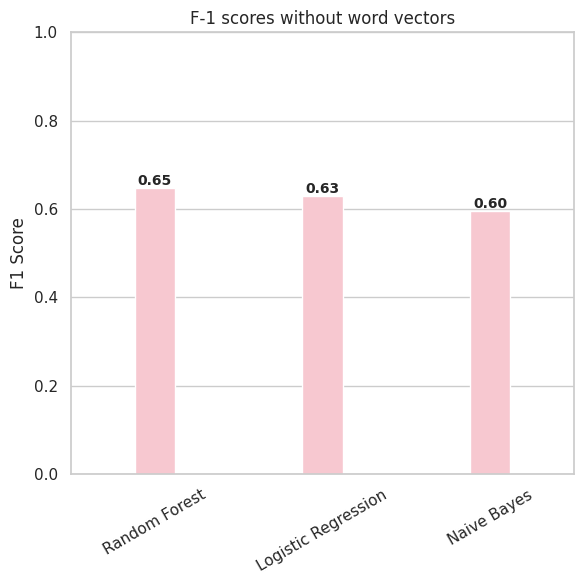

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

ax = sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), color='pink', ci=None)

for p in ax.patches:
    current_width = p.get_width()
    new_width = current_width * 0.3
    diff = current_width - new_width
    p.set_width(new_width)
    p.set_x(p.get_x() + diff / 2)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('F-1 scores without word vectors')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

<ipython-input-44-5048c164777b>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Model', y='F1-score', data=df, color='skyblue', ci=None)


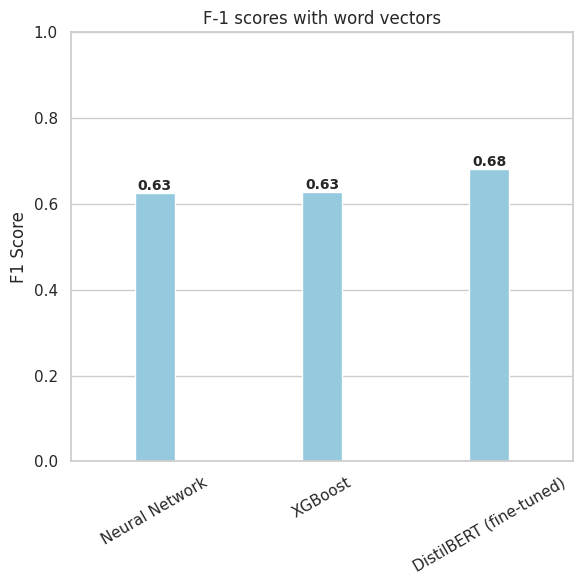

In [44]:
data = {
    'Model': ['Neural Network', 'XGBoost', 'DistilBERT (fine-tuned)'],
    'F1-score': [report_mlp['weighted avg']['f1-score'], report_xgb['weighted avg']['f1-score'], report_bert['weighted avg']['f1-score']],
}

df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

ax = sns.barplot(x='Model', y='F1-score', data=df, color='skyblue', ci=None)

for p in ax.patches:
    current_width = p.get_width()
    new_width = current_width * 0.3
    diff = current_width - new_width
    p.set_width(new_width)
    p.set_x(p.get_x() + diff / 2)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('F-1 scores with word vectors')
plt.ylabel('F1 Score')
plt.xlabel('')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()